In [2]:

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
import ssapp.Utils as Utils
torch.manual_seed(42)
import seaborn as sns
sns.set_theme()

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.models.HelperFunctions import loadModel



BATCH_SIZE = 1
dataset = PatchAntennaDataset()
train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)


train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)


DEFAULT_CONFIG = {
    "learning_rate": 4e-4,
    "epochs": 20000,
    "batch_size": 1,
    "latent_size": 2,
    "number_cuts" : 343,
    "random_seed" : 42,
    'coder_channel_1': 11,
    'coder_channel_2': 60,
    'cuts': 343}

model = loadModel(PatchAntenna1ConvAutoEncoder(config = DEFAULT_CONFIG),'treasured-haze-99') # Good 2-dimensional latent space

print(model)

print('3'+'3')

PatchAntenna1ConvAutoEncoder(
  (conv_encoder1): Conv2d(4, 11, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv_encoder2): Conv2d(11, 60, kernel_size=(3, 3), stride=(2, 2))
  (linear_to_latent): Linear(in_features=5400, out_features=2, bias=True)
  (latent_to_linear): Linear(in_features=2, out_features=5400, bias=True)
  (conv_decoder1): ConvTranspose2d(60, 11, kernel_size=(3, 3), stride=(2, 2), output_padding=(0, 1))
  (conv_decoder2): ConvTranspose2d(11, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (activation): LeakyReLU(negative_slope=0.01)
)
33


tensor([[-1.3333,  9.0000,  3.1000]])


AttributeError: 'NoneType' object has no attribute 'append'

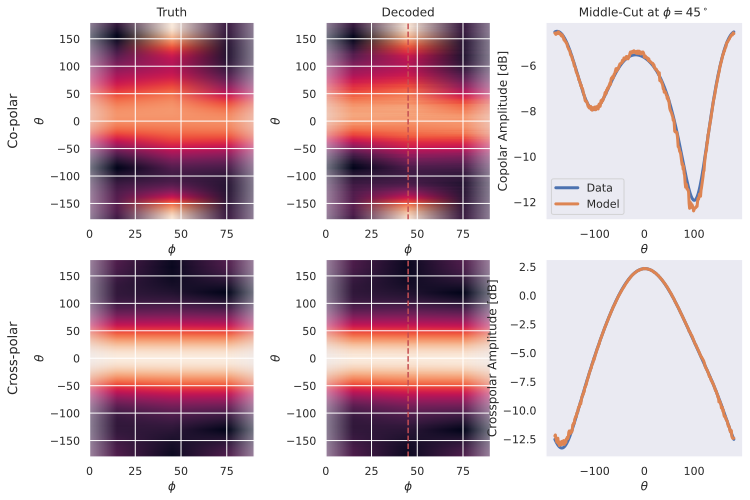

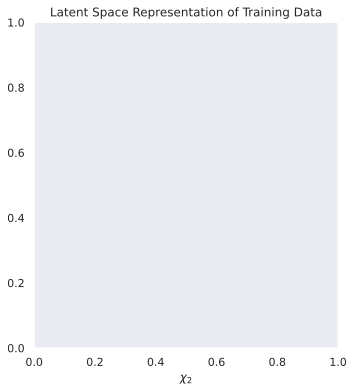

In [3]:
def plotEncodingVerificaiton(model, train_field):
    plt.figure(figsize = (15,10))
    plt.subplot(231)
    plt.imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100)
    plt.subplot(232)
    plt.imshow(torch.abs(model(train_field.float())[0,:,:,1:2]).detach(),aspect = 1/100) 
    plt.subplot(233)
    plt.plot(10*torch.log10(torch.abs(train_field[0,:,1,1:2])))
    plt.plot(10*torch.log10(torch.abs(model(train_field.float())[0,:,1,1:2])).detach()) 
    plt.subplot(234)
    plt.imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100)
    plt.subplot(235)
    plt.imshow(torch.abs(model(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100)
    plt.subplot(236)
    plt.plot(10*torch.log10(torch.abs(train_field[0,:,1,3:4])))
    plt.plot(10*torch.log10(torch.abs(model(train_field.float()))[0,:,1,3:4]).detach()) 
    
def plotEncodingVerificaiton2(model, train_field):

    EXTENT = [0,90,-180,180]
    ASPECT = 0.3
    LINEWIDTH = 3
    X_TEXT_DISPLACEMENT = -45
    thetas = np.linspace(-180,180,361)
    def setImgAxis(ax):
        ax.set_xlabel(r'$ \phi $')
        ax.set_ylabel(r'$ \theta $')
        ax.set_aspect(ASPECT) 

    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axs[0,0].imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[0,0].set_title('Truth')
    axs[0,0].text(X_TEXT_DISPLACEMENT,0,'Co-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[0,0])

    axs[0,1].imshow(torch.abs(model(train_field.float())[0,:,:,1:2]).detach(), interpolation = 'none',extent=EXTENT)
    axs[0,1].set_title('Decoded')
    axs[0,1].axvline(x = 45, color = 'r', linestyle = '--')
    setImgAxis(axs[0,1])

    axs[0,2].plot(thetas,10*torch.log10(torch.abs(train_field[0,:,1,1:2])),label = 'Data',linewidth = LINEWIDTH)
    axs[0,2].plot(thetas,10*torch.log10(torch.abs(model(train_field.float())[0,:,1,1:2])).detach(),label = 'Model',linewidth = LINEWIDTH) 
    axs[0,2].grid()
    axs[0,2].set_title('Middle-Cut at $\phi = 45^\circ$')
    axs[0,2].set_xlabel(r'$\theta$')
    axs[0,2].legend()
    axs[0,2].set_ylabel('Copolar Amplitude [dB]')

    axs[1,0].imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[1,0].text(X_TEXT_DISPLACEMENT,0,'Cross-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[1,0]) 
    

    axs[1,1].imshow(torch.abs(model(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100, interpolation = 'none',extent=EXTENT) 
    setImgAxis(axs[1,1])
    axs[1,1].axvline(x = 45, color = 'r', linestyle = '--')

    axs[1,2].plot(thetas,10*torch.log10(torch.abs(train_field[0,:,1,3:4])),linewidth = LINEWIDTH)
    axs[1,2].plot(thetas,10*torch.log10(torch.abs(model(train_field.float())[0,:,1,3:4])).detach(),linewidth = LINEWIDTH) 
    axs[1,2].set_xlabel(r'$\theta$')
    axs[1,2].grid()
    axs[1,2].set_ylabel('Crosspolar Amplitude [dB]')
    

def plotLatentSpace(model,train_loader,test_loader):
    # Model has to have a 2-dimensional latent space!
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title('Latent Space Representation of Training Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()

    x,y = ([],[])
    for param,fields in train_loader:
        
        x_t,y_t = model.encode(fields.float()).detach().numpy()
        x.append(x_t)
        y = y.append(y_t)
        
    plt.scatter(x,y, c = param[0,1])
    print(param)


    plt.subplot(122)
    plt.title('Latent Space Representation of Test Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()
    for param,fields in test_loader:
        x,y = model.encode(fields.float()).detach().numpy()
        plt.scatter(x,y, c = param[0,1])
    

TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(train_loader))

print(TEST_PARAMS)
plotEncodingVerificaiton2(model,train_field=TEST_FIELDS)
    
plotLatentSpace(model,train_loader=train_loader,test_loader=test_loader)


/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[6.10244959e-01 3.46967224e-01 2.78481956e-02 1.46497892e-02
 2.71847412e-04 1.04798232e-05 5.19358623e-06 1.15855629e-06
 7.99178702e-07 1.73581899e-07]
0.9999998190530177
torch.Size([240, 4332])
torch.Size([240, 3])


/tmp/ipykernel_779/2236546246.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])
/tmp/ipykernel_779/2236546246.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])


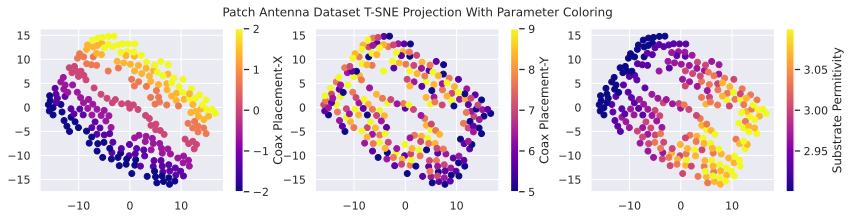

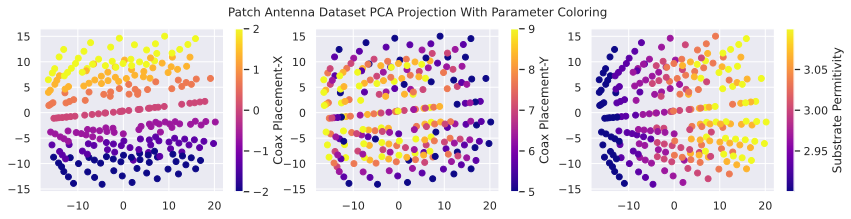

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

bs = 240

train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bs,shuffle=True)
TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(train_loader))


tsne = TSNE(n_components=2, perplexity=30, n_iter=5000,init='pca')
pca = PCA(n_components=10)


tsne_results = tsne.fit_transform(TEST_FIELDS.reshape((bs,-1)))
pca_results = pca.fit_transform(TEST_FIELDS.reshape((bs,-1)))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

print(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)).shape)
print(TEST_PARAMS.reshape((len(TEST_FIELDS),-1)).shape)

param_names = ['Coax Placement-X','Coax Placement-Y','Substrate Permitivity']

fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,3))
fig.suptitle('Patch Antenna Dataset T-SNE Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(tsne_results[:,0],tsne_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,3))
fig.suptitle('Patch Antenna Dataset PCA Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


Text(0, 0.5, 'Variance Explained %')

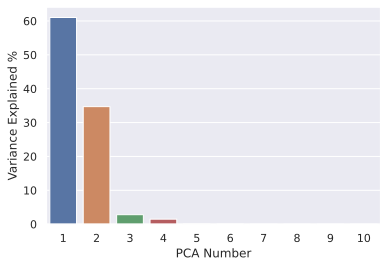

In [35]:

plt.figure()
sns.barplot(x = list(range(1,1+len(pca.explained_variance_ratio_))),y = pca.explained_variance_ratio_*100)
plt.xlabel('PCA Number')
plt.ylabel('Variance Explained %')
